In [2]:
import importlib
import gym_model
importlib.reload(gym_model)
from visualisation import JupyterVizGym, GymDrawer
from optimization import LayoutTemplate
import random

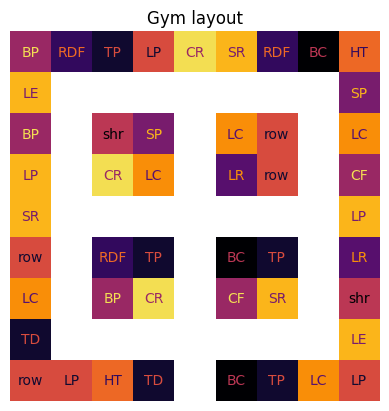

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gym_agent import Muscle
from visualisation import draw_layout

tpl = LayoutTemplate.square_isles(isle_rows=2, isle_cols=2)
layout = tpl.instantiate([random.choice(list(gym_model.Equipment)) for _ in range(len(tpl))])
# print(list(zip(*np.where(layout != None))))
draw_layout(layout, show=True, cmap_name="inferno")

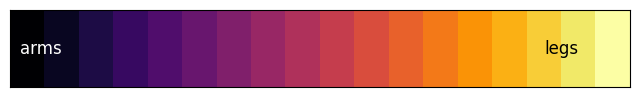

In [35]:
# Get the colormap
cmap = plt.get_cmap('inferno')

# Get the number of segments
num_segments = len(gym_model.Equipment)

# Create a list of values from 0 to 1
values = np.linspace(0, 1, num_segments)

# Plot the spectrum
plt.figure(figsize=(8, 1))
plt.imshow([values], cmap=cmap, aspect='auto')
plt.xticks([])
plt.yticks([])

# Add text "arms" on the left
plt.text(1, 0, "arms", ha='right', va='center', fontsize=12, color='white')

# Add text "legs" on the right
plt.text(15, 0, "legs", ha='left', va='center', fontsize=12, color='black')

plt.show()


In [29]:
model_params = {
    "interarrival_time": {
        "type": "SliderInt",
        "value": 2,
        "label": "time between arrivals:",
        "min": 1,
        "max": 50,
        "step": 1,
    },
    "agent_exercise_duration": {
        "type": "SliderInt",
        "value": 20,
        "label": "mean exercise duration:",
        "min": 1,
        "max": 3 * 60,
        "step": 1,
    },
}

RANDOM_LAYOUT = False

if RANDOM_LAYOUT:
    model_params["machine_density"] ={
        "type": "SliderFloat",
        "value": 0.25,
        "label": "Density of gym equipment:",
        "min": 0.05,
        "max": 1,
        "step": 0.05,
    }
else:
    template = LayoutTemplate.square_isles(isle_rows=2, isle_cols=2)
    model_params["layout"] = template.instantiate([random.choice(list(gym_model.Equipment)) for _ in range(len(template))])
    model_params["spawn_location"] = template.entrance


page = JupyterVizGym(
    gym_model.Gym,
    model_params,
    measures=["Congestion", "Utilization"],
    name="Test gym",
    agent_portrayal=lambda agent: agent.portrayal,
    # space_drawer="default",
    space_drawer=GymDrawer,
)

page

Cannot show ipywidgets in text

In [36]:
gym = gym_model.Gym(interarrival_time=2, agent_exercise_duration=3)

model_df, agent_df = gym.run(20, progress_bar=True)
agent_df

Simulating gym: 100%|██████████| 20/20 [00:00<00:00, 647.96it/s, 11 agents]


State
Step AgentID             
0    0          SEARCHING
1    0          SEARCHING
     1          SEARCHING
2    0          SEARCHING
     1        WORKING_OUT
...                   ...
19   6          SEARCHING
     7        WORKING_OUT
     8          SEARCHING
     9        WORKING_OUT
     10         SEARCHING

[120 rows x 1 columns]

In [41]:
agent_total_time = agent_df.groupby("AgentID").size()
agent_total_time

AgentID
0     20
1     19
2     17
3     15
4     13
5     11
6      9
7      7
8      5
9      3
10     1
dtype: int64

In [11]:
agent_state_counter = agent_df.groupby(['AgentID', 'State']).size()#.reset_index(name='Count')
agent_state_counter

AgentID  State      
0        SEARCHING      3
         WORKING_OUT    7
1        SEARCHING      7
         WORKING_OUT    3
2        SEARCHING      3
         WORKING_OUT    6
3        SEARCHING      2
         WORKING_OUT    6
4        SEARCHING      4
         WORKING_OUT    3
5        SEARCHING      2
         WORKING_OUT    4
6        SEARCHING      2
         WORKING_OUT    3
7        SEARCHING      1
         WORKING_OUT    3
8        SEARCHING      1
         WORKING_OUT    2
9        SEARCHING      1
         WORKING_OUT    1
10       SEARCHING      1
dtype: int64

In [43]:
steps_working_out = agent_df[agent_df['State'] == 'WORKING_OUT'].groupby('AgentID').size()
steps_working_out


AgentID
0    12
1     9
2     8
3     8
4     9
5     6
6     6
7     5
8     3
9     2
dtype: int64

In [46]:

# Compute the efficiency ratio for each AgentID
efficiency_ratio = steps_working_out / agent_total_time
efficiency_ratio.fillna(0, inplace=True) # some of them don't even lift (bruh)
efficiency_ratio

AgentID
0     0.600000
1     0.473684
2     0.470588
3     0.533333
4     0.692308
5     0.545455
6     0.666667
7     0.714286
8     0.600000
9     0.666667
10    0.000000
dtype: float64

In [34]:
efficiency_ratio.mean()

10.137483761760341